In [1]:
import pandas as pd
from tree_based_models import model_selection_using_kfold, get_model, evaluate_model
from data_engineering import feature_engineering as fe

## Load Data

In [2]:
train = pd.read_csv("data/train.csv")
X_val = pd.read_csv("data/X_val.csv")
y_val = pd.read_csv("data/y_val.csv")

## Define Features names

In [3]:
RET_features = [f"RET_{i}" for i in range(1, 21)]
SIGNED_VOLUME_features = [f"SIGNED_VOLUME_{i}" for i in range(1, 21)]
TURNOVER_features = ["AVG_DAILY_TURNOVER"]

window_sizes = [1, 3, 5, 10, 15, 20]

## Define Feature Engineering

In [4]:
def feature_engineering(
    X: pd.DataFrame,
) -> pd.DataFrame:
    X = (
        X.pipe(
            fe.scale_features,
            RET_features=RET_features,
            SIGNED_VOLUME_features=SIGNED_VOLUME_features,
        )
        .pipe(
            fe.add_average_perf_features,
            RET_features=RET_features,
            window_sizes=window_sizes,
            group_col="TS",
        )
        .pipe(
            fe.add_return_to_volume_ratio,
            RET_features=RET_features,
            SIGNED_VOLUME_features=SIGNED_VOLUME_features,
        )
        .pipe(
            fe.add_statistical_features,
            RET_features=RET_features,
            SIGNED_VOLUME_features=SIGNED_VOLUME_features,
        )
    )

    return X


X_feat = feature_engineering(train)
features = [
    col
    for col in X_feat.columns
    if col not in ["ROW_ID", "TS", "ALLOCATION", "target"] + SIGNED_VOLUME_features
]

## Define Parameters

In [5]:
target_name = "target"
unique_id = "TS"
model_name = "xgb"

##  Model Evaluation using Cross Validation

Fold 1 - Accuracy: 51.22%
Fold 2 - Accuracy: 52.03%
Fold 3 - Accuracy: 51.81%
Fold 4 - Accuracy: 52.16%
Accuracy: 51.80% (± 0.36%) [Min: 51.22% ; Max: 52.16%]

Top 10 important features:
['VOL_KURT', 'RET_1', 'RET_4', 'AVG_RET_7_DIV_SIGNED_VOLUME_7', 'AVG_DAILY_TURNOVER', 'AVERAGE_PERF_5', 'RET_3_DIV_SIGNED_VOLUME_3', 'SCALED_SIGNED_VOLUME_1', 'RET_4_DIV_SIGNED_VOLUME_4', 'AVERAGE_PERF_1']


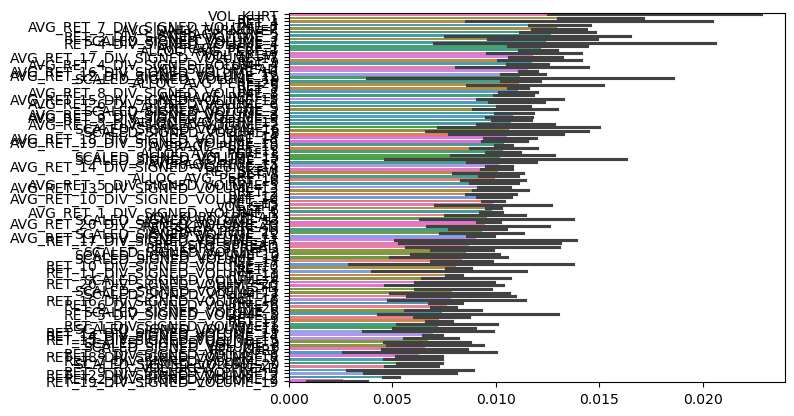

In [6]:
model_selection_using_kfold(
    data=train,
    target=target_name,
    features=features,
    feat_engineering=feature_engineering,
    model_type=model_name,
    unique_id=unique_id,
    plot_ft_importance=True,
    n_splits=4,
)

## Train Model and test on X_val

In [7]:
if feature_engineering:
    train = feature_engineering(train)
    X_val = feature_engineering(X_val)

model = get_model(model_name)
model.fit(train[features], train[target_name])

_ = evaluate_model(
    model=model, X=X_val[features], y=y_val[target_name], verbose=True, log=False
)

Model evaluation: accuracy: 51.90 %


## Prediction

In [8]:
X_test = pd.read_csv("data/X_test.csv")

if feature_engineering:
    X_test = feature_engineering(X_test)


preds_sub = model.predict(X_test[features])
preds_sub = pd.DataFrame(preds_sub, index=X_test["ROW_ID"], columns=[target_name])
preds_sub["target"] = 1

# (preds_sub > 0).astype(int).to_csv(f"predictions/preds_{model_name}.csv")